In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2024-11-02 09:51:39.191660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 09:51:39.202266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 09:51:39.205507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1730541100.363397  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541100.391292  130693 cuda_executor.cc:1015] succ


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig()
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        frozen_insertions=True,
                                        num_prior_components=10,
                                        V2_emitter=True,
                                        V2_temperature=3.)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens))) #comment out to disable cropping
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [25 24 24 26] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730541165.157478  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541165.157788  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541165.158013  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541165.158265  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730541167.264637  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541167.265716  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541167.266243  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541167.266935  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 17s - 377ms/step - loss: 110.8104 - loglik: -9.4075e+01 - prior: -1.6530e+01 - aux_loss: 0.2053
Epoch 2/10
46/46 - 3s - 56ms/step - loss: 76.0724 - loglik: -7.1408e+01 - prior: -4.1372e+00 - aux_loss: 0.5274
Epoch 3/10
46/46 - 3s - 56ms/step - loss: 72.7317 - loglik: -6.9505e+01 - prior: -2.6845e+00 - aux_loss: 0.5418
Epoch 4/10
46/46 - 3s - 57ms/step - loss: 71.9861 - loglik: -6.9200e+01 - prior: -2.2415e+00 - aux_loss: 0.5448
Epoch 5/10
46/46 - 3s - 55ms/step - loss: 71.8331 - loglik: -6.9208e+01 - prior: -2.0797e+00 - aux_loss: 0.5450
Epoch 6/10
46/46 - 3s - 59ms/step - loss: 71.6145 - loglik: -6.9069e+01 - prior: -2.0014e+00 - aux_loss: 0.5441
Epoch 7/10
46/46 - 3s - 71ms/step - loss: 71.6585 - loglik: -6.9154e+01 - prior: -1.9605e+00 - aux_loss: 0.5436
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.


I0000 00:00:1730541202.659631  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541202.659903  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541202.660090  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541202.660305  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 3), (14, 1), (15, 1), (16, 1)]
discards model 0: []
expansions model 1: [(12, 7), (13, 1)]
discards model 1: []
expansions model 2: [(10, 1), (11, 7)]
discards model 2: []
expansions model 3: [(0, 1), (12, 2), (13, 3), (16, 1), (17, 1)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [33, 32, 32, 34] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730541207.347958  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541207.348263  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541207.348483  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541207.348734  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


I0000 00:00:1730541209.002293  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541209.002557  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541209.002744  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541209.002960  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 17s - 365ms/step - loss: 83.2290 - loglik: -6.4225e+01 - prior: -1.8530e+01 - aux_loss: 0.4742
Epoch 2/4
46/46 - 4s - 76ms/step - loss: 67.8370 - loglik: -6.2926e+01 - prior: -4.3826e+00 - aux_loss: 0.5282
Epoch 3/4
46/46 - 4s - 78ms/step - loss: 66.0688 - loglik: -6.3052e+01 - prior: -2.4883e+00 - aux_loss: 0.5286
Epoch 4/4
46/46 - 3s - 71ms/step - loss: 65.5727 - loglik: -6.3191e+01 - prior: -1.8545e+00 - aux_loss: 0.5272
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.


I0000 00:00:1730541237.917971  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541237.918242  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541237.918435  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541237.918666  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: [12 15]
expansions model 1: []
discards model 1: [15]
expansions model 2: []
discards model 2: [15]
expansions model 3: []
discards model 3: [ 0 13 16]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730541242.541605  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541242.541905  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541242.542126  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541242.542375  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


I0000 00:00:1730541244.237321  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541244.237580  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541244.237766  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541244.237980  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 17s - 363ms/step - loss: 78.9821 - loglik: -6.1908e+01 - prior: -1.6514e+01 - aux_loss: 0.5598
Epoch 2/4
46/46 - 4s - 78ms/step - loss: 67.0212 - loglik: -6.2633e+01 - prior: -3.8267e+00 - aux_loss: 0.5611
Epoch 3/4
46/46 - 4s - 76ms/step - loss: 65.8926 - loglik: -6.3196e+01 - prior: -2.1362e+00 - aux_loss: 0.5600
Epoch 4/4
46/46 - 3s - 75ms/step - loss: 65.3387 - loglik: -6.3244e+01 - prior: -1.5339e+00 - aux_loss: 0.5605
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.


I0000 00:00:1730541272.783199  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541272.783461  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541272.783646  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541272.783870  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: []
expansions model 1: []
discards model 1: []
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730541277.568369  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541277.568630  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541277.568812  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541277.569025  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1730541279.244693  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541279.244953  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541279.245138  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541279.245353  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 17s - 364ms/step - loss: 77.0443 - loglik: -6.1912e+01 - prior: -1.4571e+01 - aux_loss: 0.5606
Epoch 2/20
46/46 - 4s - 78ms/step - loss: 66.5194 - loglik: -6.2716e+01 - prior: -3.2430e+00 - aux_loss: 0.5608
Epoch 3/20
46/46 - 4s - 79ms/step - loss: 65.5376 - loglik: -6.3197e+01 - prior: -1.7799e+00 - aux_loss: 0.5605
Epoch 4/20
46/46 - 4s - 79ms/step - loss: 65.1457 - loglik: -6.3295e+01 - prior: -1.2910e+00 - aux_loss: 0.5593
Epoch 5/20
46/46 - 3s - 75ms/step - loss: 64.8304 - loglik: -6.3179e+01 - prior: -1.0889e+00 - aux_loss: 0.5621
Epoch 6/20
46/46 - 3s - 74ms/step - loss: 64.7378 - loglik: -6.3182e+01 - prior: -9.9415e-01 - aux_loss: 0.5614
Epoch 7/20
46/46 - 3s - 60ms/step - loss: 64.7533 - loglik: -6.3264e+01 - prior: -9.3092e-01 - aux_loss: 0.5584
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.
Time for alignment: 210.3505
Likelihoods:  ['-58.5061', '-58.5191', '-58.5088', '-58.5195']
Mean likelihood:  -58.513357921587584
Se

I0000 00:00:1730541320.519446  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541320.519749  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541320.519950  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541320.520171  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 3.0354
Wrote file test/data/interactive.alignment.fasta
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
>l=-52.54_t=0.01
.....................$CD.......P............NP.......CYN.HG..T..CS......................L.......RAT..GYTCSC..L....PR......YT....GEH$..........................
>l=-55.67_t=0.01
.....................$CD.......S............QP.......CRN.-G..T..CS......................Ln......TNT..DYTCAC..F....PG......YT....GRY$..........................
>l=-47.66_t=0.01
.....................$CD.......S............DP.......CLN.GG..T..CT......................Lr......SLD..SYSCAC..A....PG......YT....GQH$..........................
>l=-61.09_t=0.01
.....................$CD.......H............VT.......CLN.GG..T..CQ......................Lk......TLE..DYTCAC..A....NG......YT....GER$..........................
>l=-61.67_t=0.01
.....................$CD.......H............VT.......CLN.GG..T..CQ......................Lk......TLE..EYTCAC..A....NG......YT....GDR$.......................

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1730541327.934497  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541327.934723  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730541327.934908  130693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

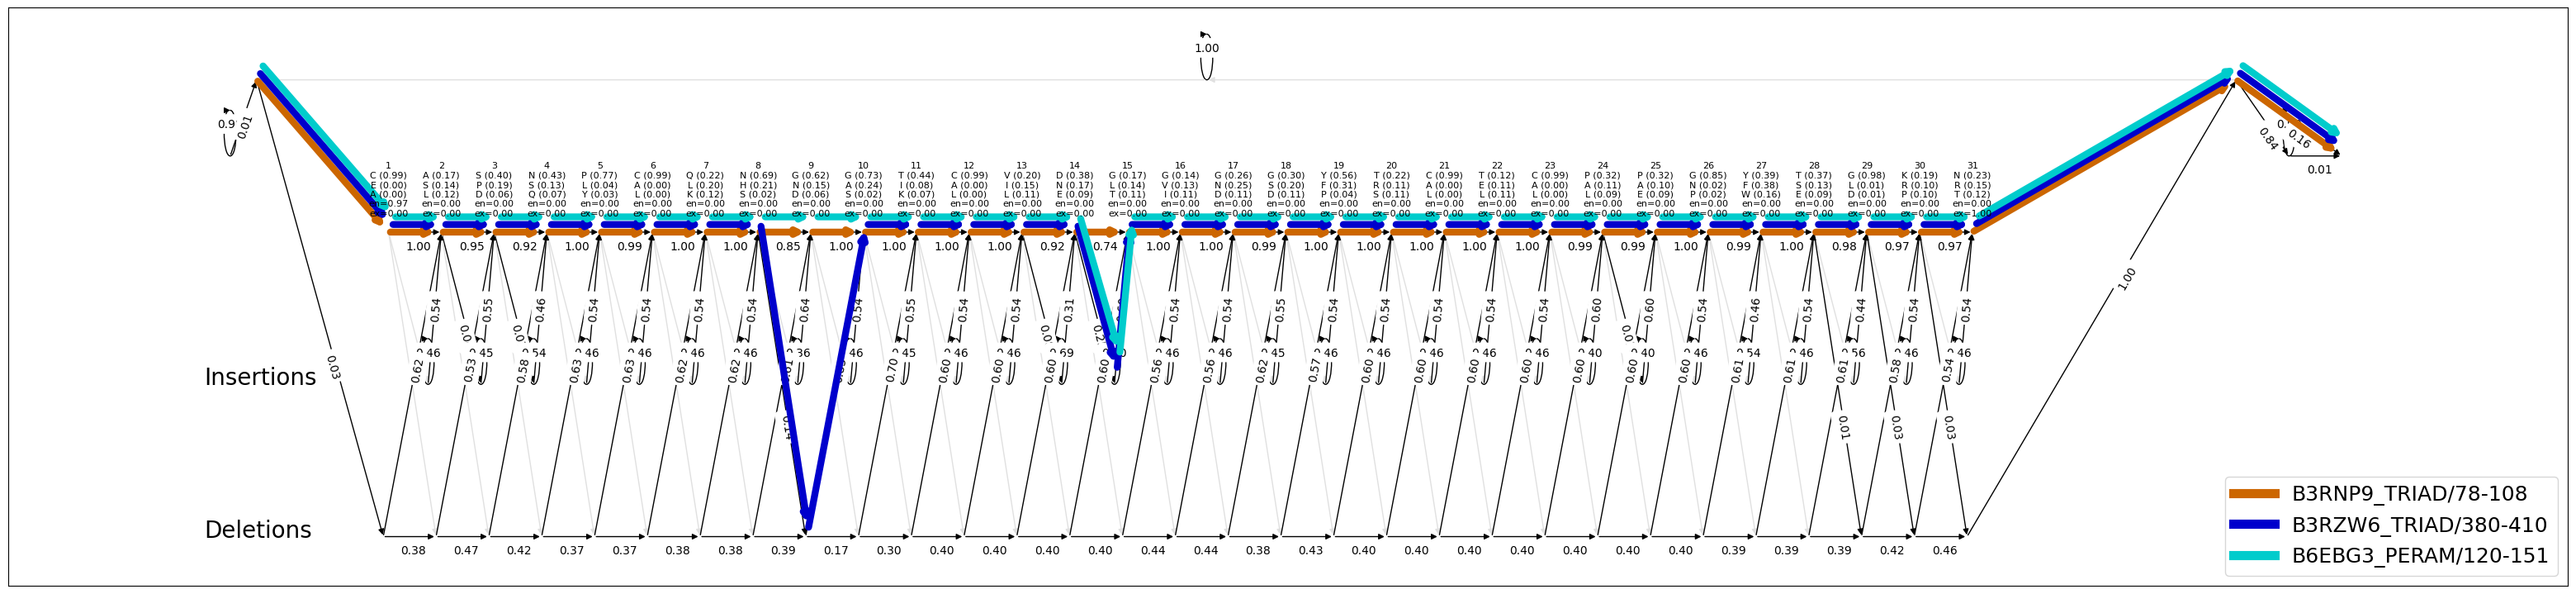

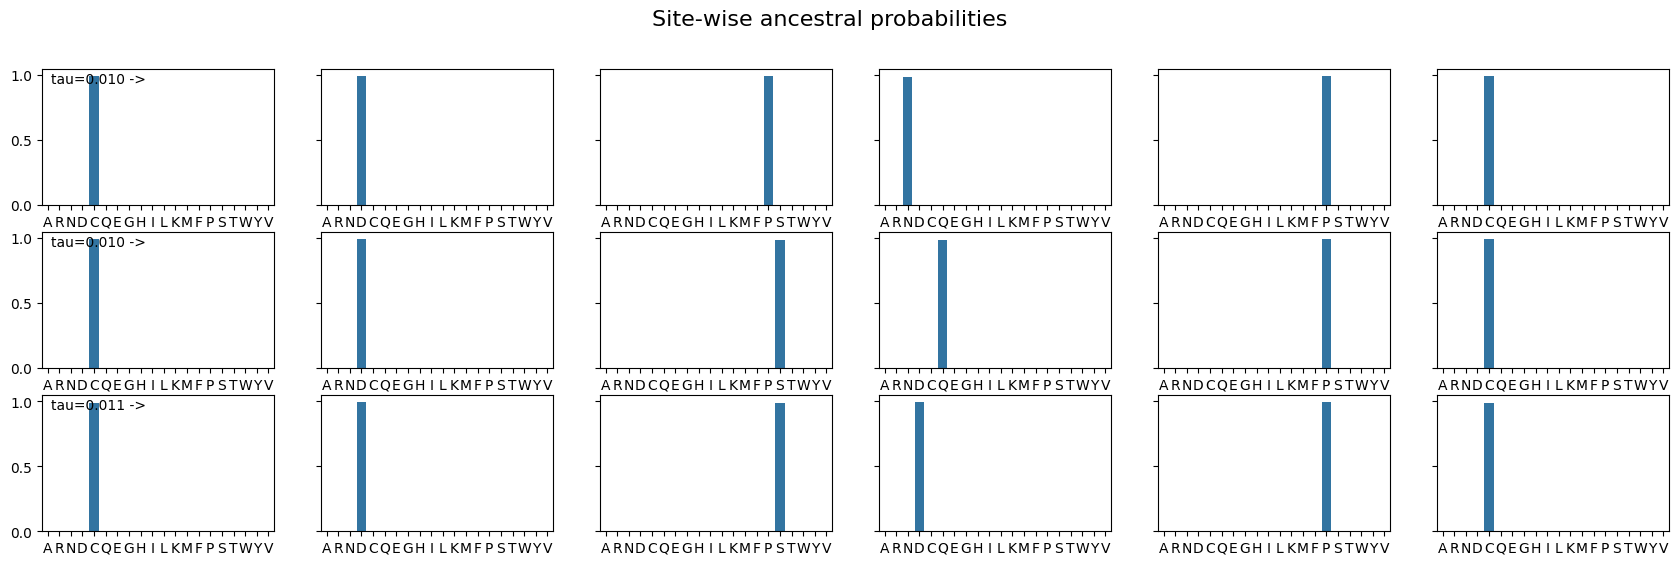

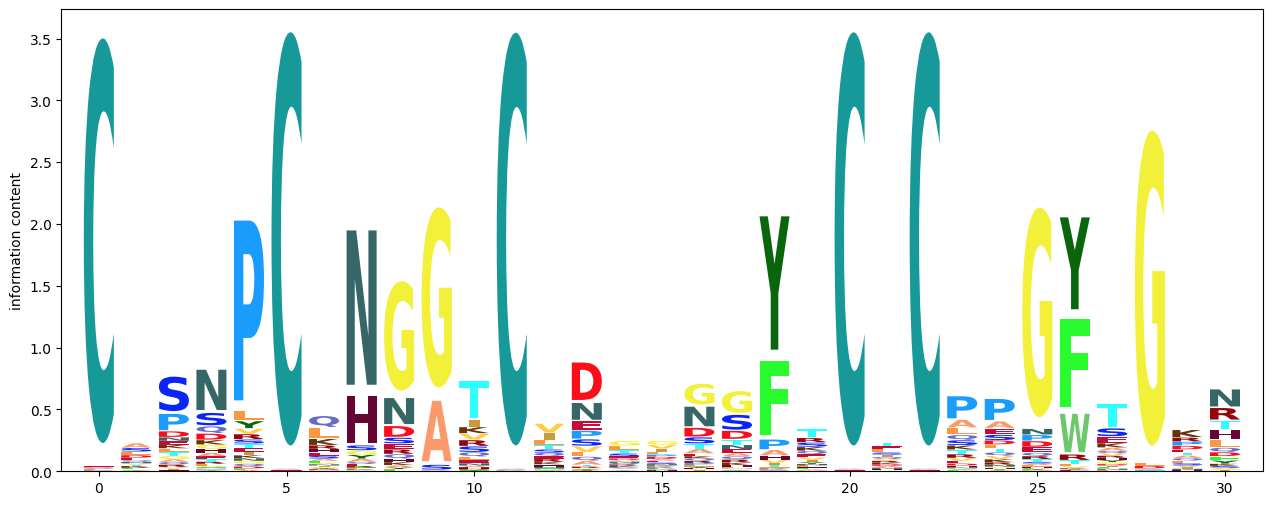

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    74.7 [100.0]   [ 5182]
